<a href="https://colab.research.google.com/github/luyuzhe111/machine-learning-foundamentals/blob/main/non_parametric_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pickle
from scipy import stats
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
with open('hw3_p2.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
x_train, y_train, x_test, y_test = data['x_train'], data['y_train'], data['x_test'], data['y_test']

In [4]:
from sklearn.metrics import mean_squared_error

### Vanilla kNN regression

In [5]:
def compare_prediction(gt, pred):
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].scatter(x_test[:, 0], x_test[:, 1], c=y_test)
  ax[0].set_title('ground truth')
  ax[1].scatter(x_test[:, 0], x_test[:, 1], c=pred)
  ax[1].set_title('prediction')
  return fig, ax

In [6]:
def poly_kernel(u, v, d):
  return np.power(1 + u @ v.T, d)

In [7]:
def regress(target, base, base_label, kernel, hp):
  dist = kernel(target, base, hp)
  weighted_dist = dist * base_label
  pred = weighted_dist.sum(1) / dist.sum(1)
  return pred

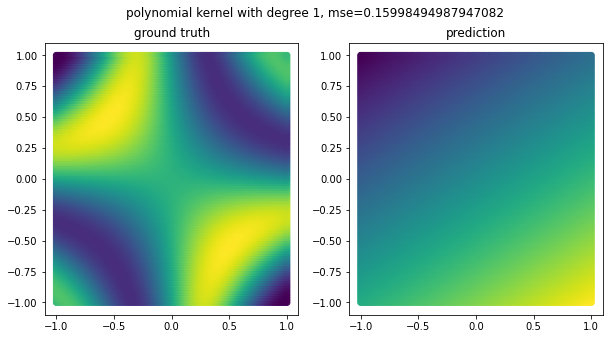

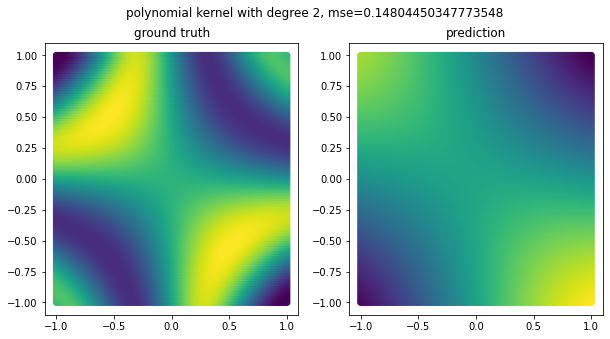

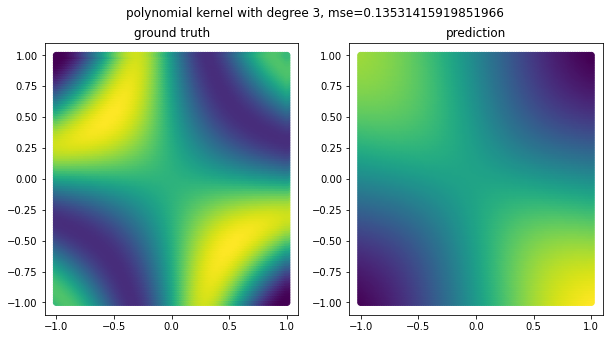

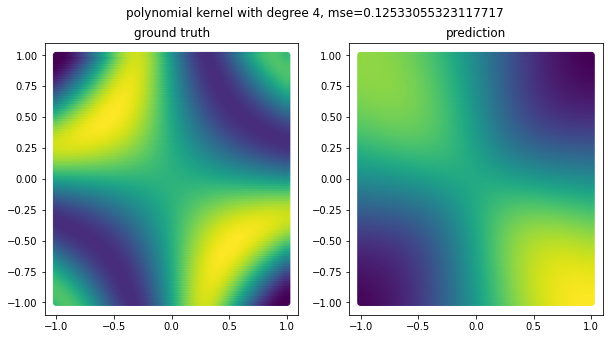

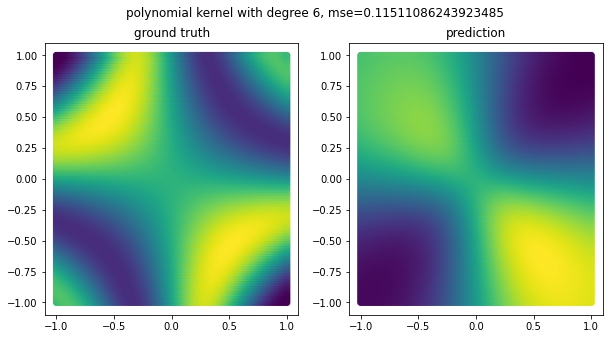

In [8]:
for i in [1, 2, 3, 4, 6]:
  pred = regress(x_test, x_train, y_train, poly_kernel, i)
  mse = mean_squared_error(y_test, pred)

  fig, ax = compare_prediction(y_test, pred)
  fig.suptitle(f'polynomial kernel with degree {i}, mse={mse}')
  plt.show()

In [9]:
def rbf_kernel(u, v, gamma):
  diff_sqr = np.sum((np.expand_dims(u, 1) - np.expand_dims(v, 0)) ** 2, axis=-1)
  return np.exp(-gamma * diff_sqr)

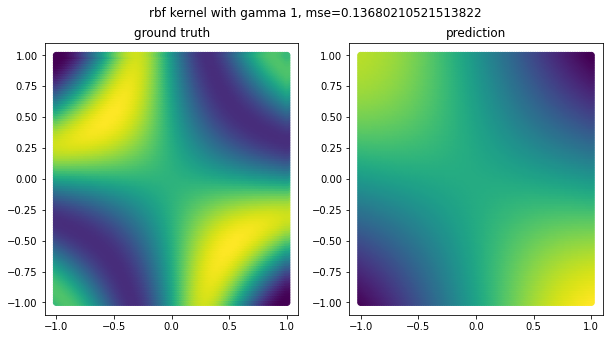

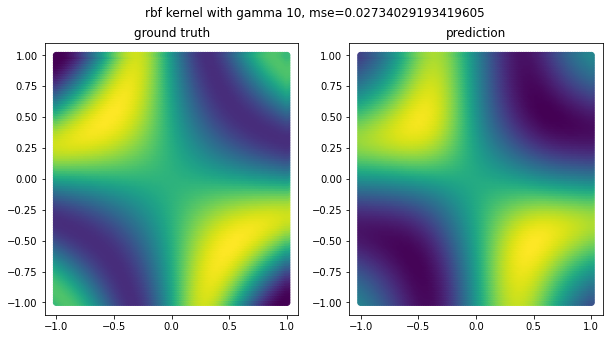

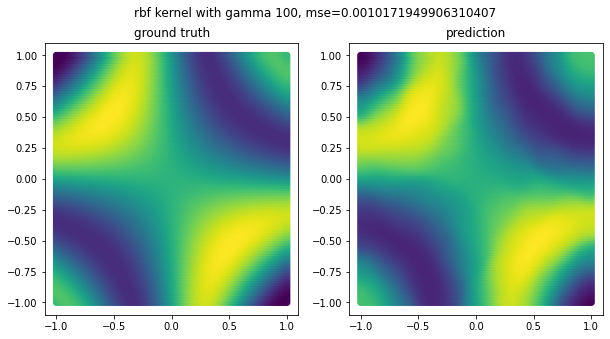

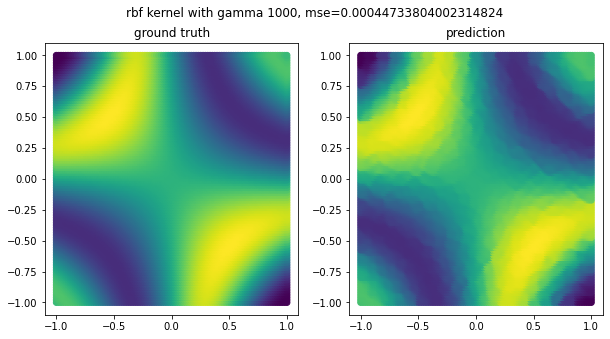

In [10]:
for gamma in [1, 10, 100, 1000]:
  pred = regress(x_test, x_train, y_train, rbf_kernel, gamma)
  mse = mean_squared_error(y_test, pred)

  fig, ax = compare_prediction(y_test, pred)
  fig.suptitle(f'rbf kernel with gamma {gamma}, mse={mse}')
  plt.show()

In [11]:
def custom_kernel(u, v, gamma):
  diff_sqr = np.sum((np.expand_dims(u, 1) - np.expand_dims(v, 0)) ** 2, axis=-1)
  rbf = np.exp(-gamma * diff_sqr)
  return -1 * rbf / (1 + rbf)

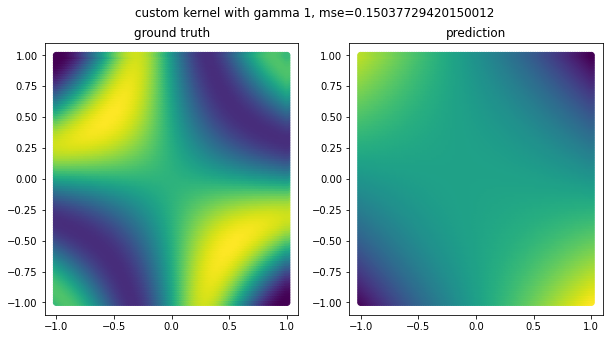

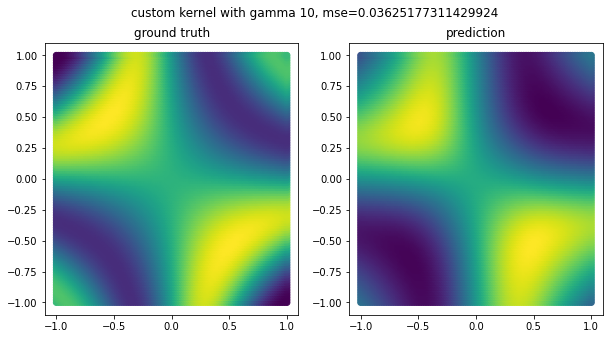

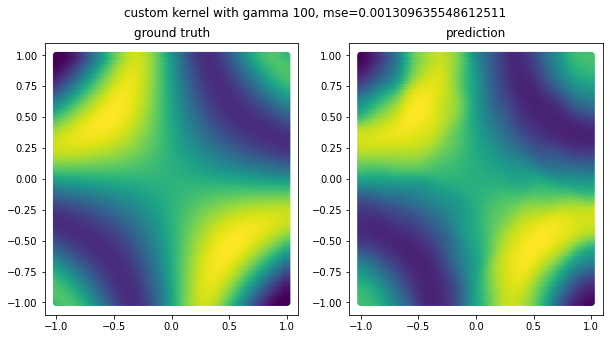

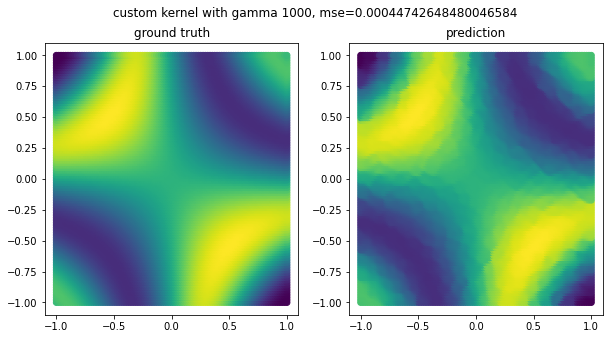

In [12]:
for gamma in [1, 10, 100, 1000]:
  pred = regress(x_test, x_train, y_train, custom_kernel, gamma)
  mse = mean_squared_error(y_test, pred)

  fig, ax = compare_prediction(y_test, pred)
  fig.suptitle(f'custom kernel with gamma {gamma}, mse={mse}')
  plt.show()

### Locality Sensitive Hashing 

In [13]:
def random_proj(inputs, L=5, state=2):
  np.random.seed(state)
  proj = np.random.normal(size=(2, L))
  unit_proj = proj / np.sqrt((proj ** 2).sum(0).reshape(1, L).repeat(2, axis=0))

  inputs_proj = ((inputs @ unit_proj) > 0).astype(np.int)
  ids = np.sum(np.power(2, np.arange(0, L)) * inputs_proj, axis=-1)
  return ids

In [14]:
from collections import defaultdict

In [15]:
def create_hash_table(inputs, targets, hash_function):
  hashcodes_y_dict = defaultdict(list)
  hashcodes_x_dict = defaultdict(list)

  train_x_codes = random_proj(inputs)
  for i in range(len(train_x_codes)):
    code = train_x_codes[i]
    hashcodes_x_dict[code].append(inputs[i])
    hashcodes_y_dict[code].append(targets[i])

  for code in hashcodes_x_dict.keys():
    hashcodes_x_dict[code] = np.stack(hashcodes_x_dict[code], axis=0)
    hashcodes_y_dict[code] = np.stack(hashcodes_y_dict[code], axis=0)
  return hashcodes_x_dict, hashcodes_y_dict

In [16]:
hashcodes_x_dict, hashcodes_y_dict = create_hash_table(x_train, y_train, random_proj)

In [17]:
test_x_codes = random_proj(x_test)

In [18]:
import time

The best non-parametric regressor is RBF kernel with gamma=1000

In [19]:
reps = 10
lsh_times = []
for _ in range(reps):
  preds = []
  start = time.time()
  for i in range(len(test_x_codes)):
    code = test_x_codes[i]
    neigh = hashcodes_x_dict[code]
    neigh_labels = hashcodes_y_dict[code]

    test_sample = x_test[i].reshape(1, 2)
    preds.extend(regress(test_sample, neigh, neigh_labels, rbf_kernel, 1000))
  lsh_times.append(time.time() - start)

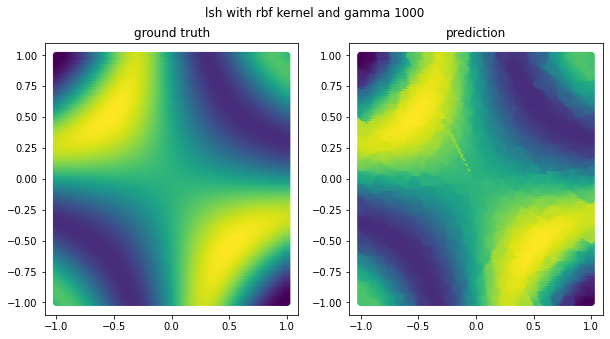

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(x_test[:, 0], x_test[:, 1], c=y_test)
ax[0].set_title('ground truth')
ax[1].scatter(x_test[:, 0], x_test[:, 1], c=preds)
ax[1].set_title('prediction')
fig.suptitle('lsh with rbf kernel and gamma 1000')
plt.show()

In [21]:
times = []
for _ in range(reps):
  start = time.time()
  baseline_preds = regress(x_test, x_train, y_train, rbf_kernel, 1000)
  times.append(time.time() - start)

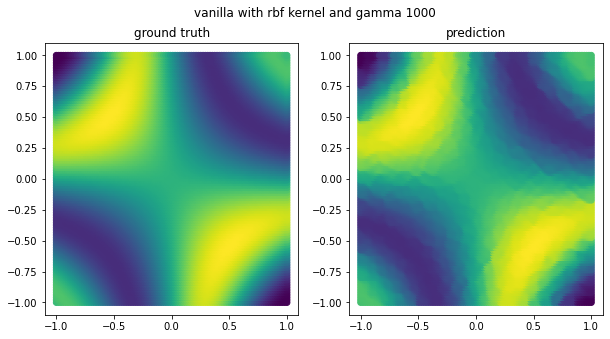

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(x_test[:, 0], x_test[:, 1], c=y_test)
ax[0].set_title('ground truth')
ax[1].scatter(x_test[:, 0], x_test[:, 1], c=baseline_preds)
ax[1].set_title('prediction')
fig.suptitle('vanilla with rbf kernel and gamma 1000')
plt.show()

In [26]:
print(f'using vanilla knn regression, average inferece time is {round(np.array(times).mean(),2)}s')
print(f'using lsh ann regression, average inferece time is {round(np.array(lsh_times).mean(),2)}s')

using vanilla knn regression, average inferece time is 1.23s
using lsh ann regression, average inferece time is 0.53s
